In [424]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima import auto_arima
from pylab import rcParams


In [ ]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(
    period="60d", 
    interval="5m",
)

print(msft_df.head())

                                 Open        High         Low       Close  \
Datetime                                                                    
2025-03-19 09:30:00-04:00  161.910004  162.393494  161.399994  161.639999   
2025-03-19 09:35:00-04:00  161.625000  161.779999  161.270004  161.619995   
2025-03-19 09:40:00-04:00  161.639999  161.811401  161.000000  161.229996   
2025-03-19 09:45:00-04:00  161.229996  161.970001  161.154999  161.929993   
2025-03-19 09:50:00-04:00  161.934998  162.250000  161.679993  162.199997   

                            Volume  Dividends  Stock Splits  
Datetime                                                     
2025-03-19 09:30:00-04:00  1184642        0.0           0.0  
2025-03-19 09:35:00-04:00   352277        0.0           0.0  
2025-03-19 09:40:00-04:00   299108        0.0           0.0  
2025-03-19 09:45:00-04:00   305420        0.0           0.0  
2025-03-19 09:50:00-04:00   239305        0.0           0.0  


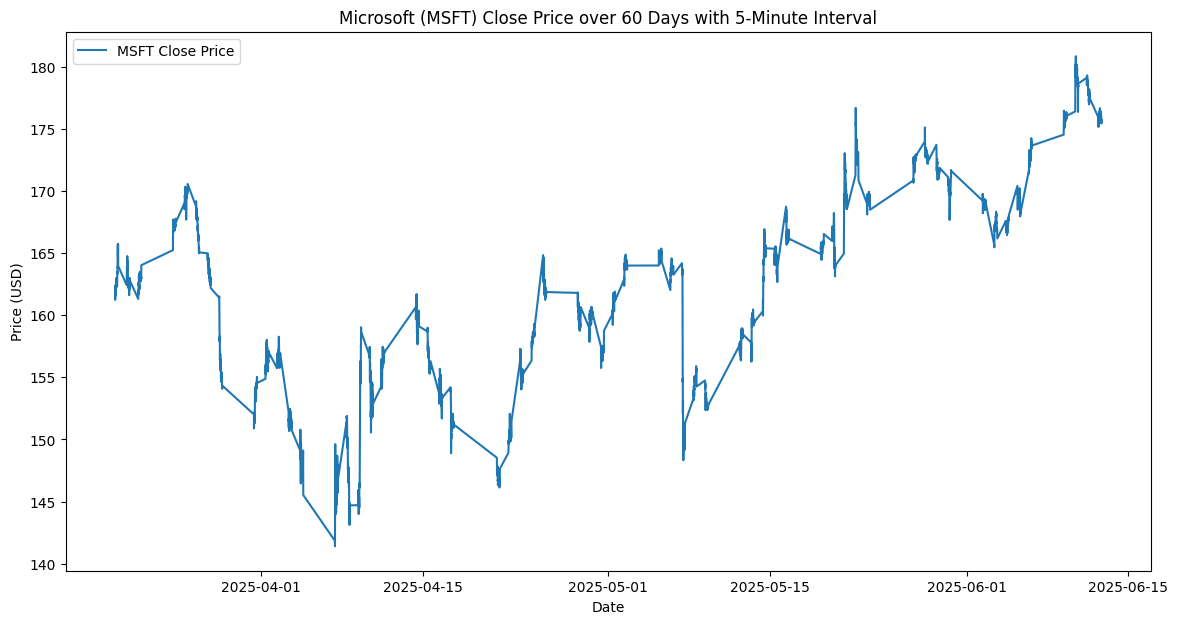

In [426]:
plt.figure(figsize=(14, 7))
plt.plot(msft_df.index, msft_df['Close'], label='MSFT Close Price')
plt.title('Microsoft (MSFT) Close Price over 60 Days with 5-Minute Interval')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend();

# Testing For Stationarity

Results of dickey fuller test
Test Statistics                  -1.439000
p-value                           0.563443
No. of lags used                  2.000000
Number of observations used    4676.000000
critical value (1%)              -3.431749
critical value (5%)              -2.862158
critical value (10%)             -2.567099
dtype: float64


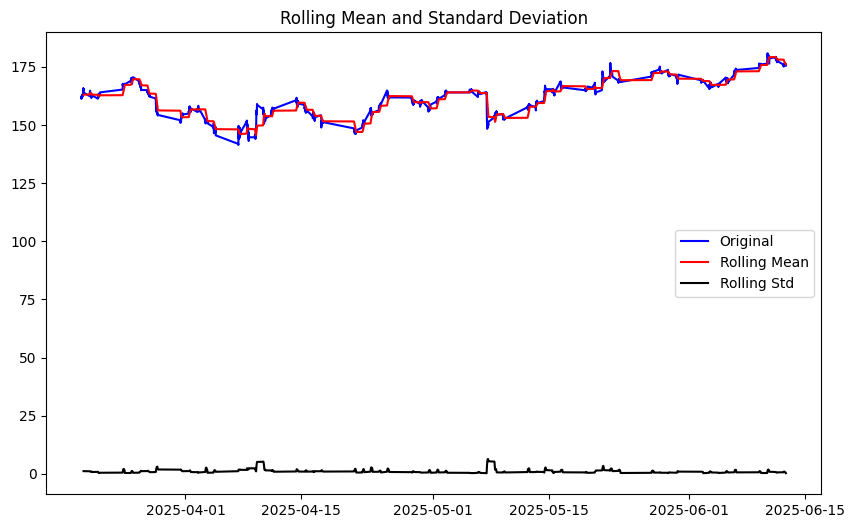

In [427]:

def test_stationarity(timeseries):
   
    rolmean = timeseries.rolling(78).mean()
    rolstd = timeseries.rolling(78).std()
 
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(msft_df['Close'])

Interpretation: 
* Null Hypothesis: The time series is non-stationary.
* Alternative Hypothesis: The time series is stationary.

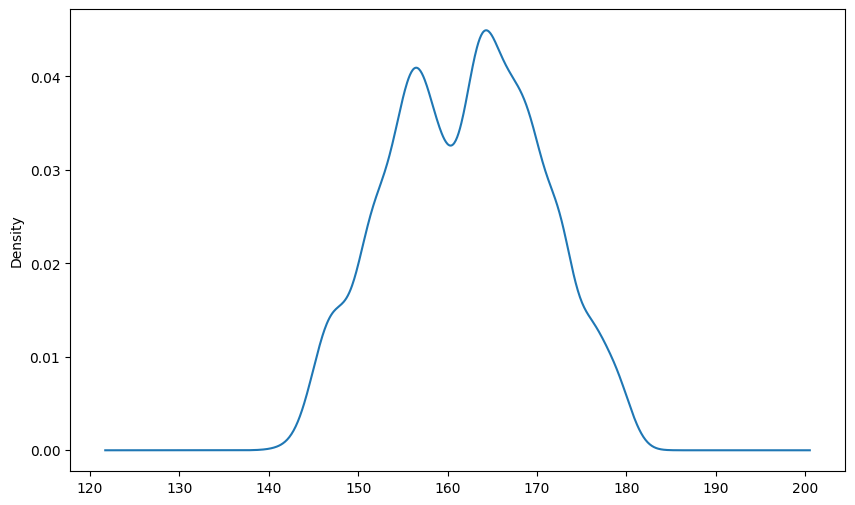

In [428]:
msft_df['Close'].plot(kind='kde');

<Figure size 1000x600 with 0 Axes>

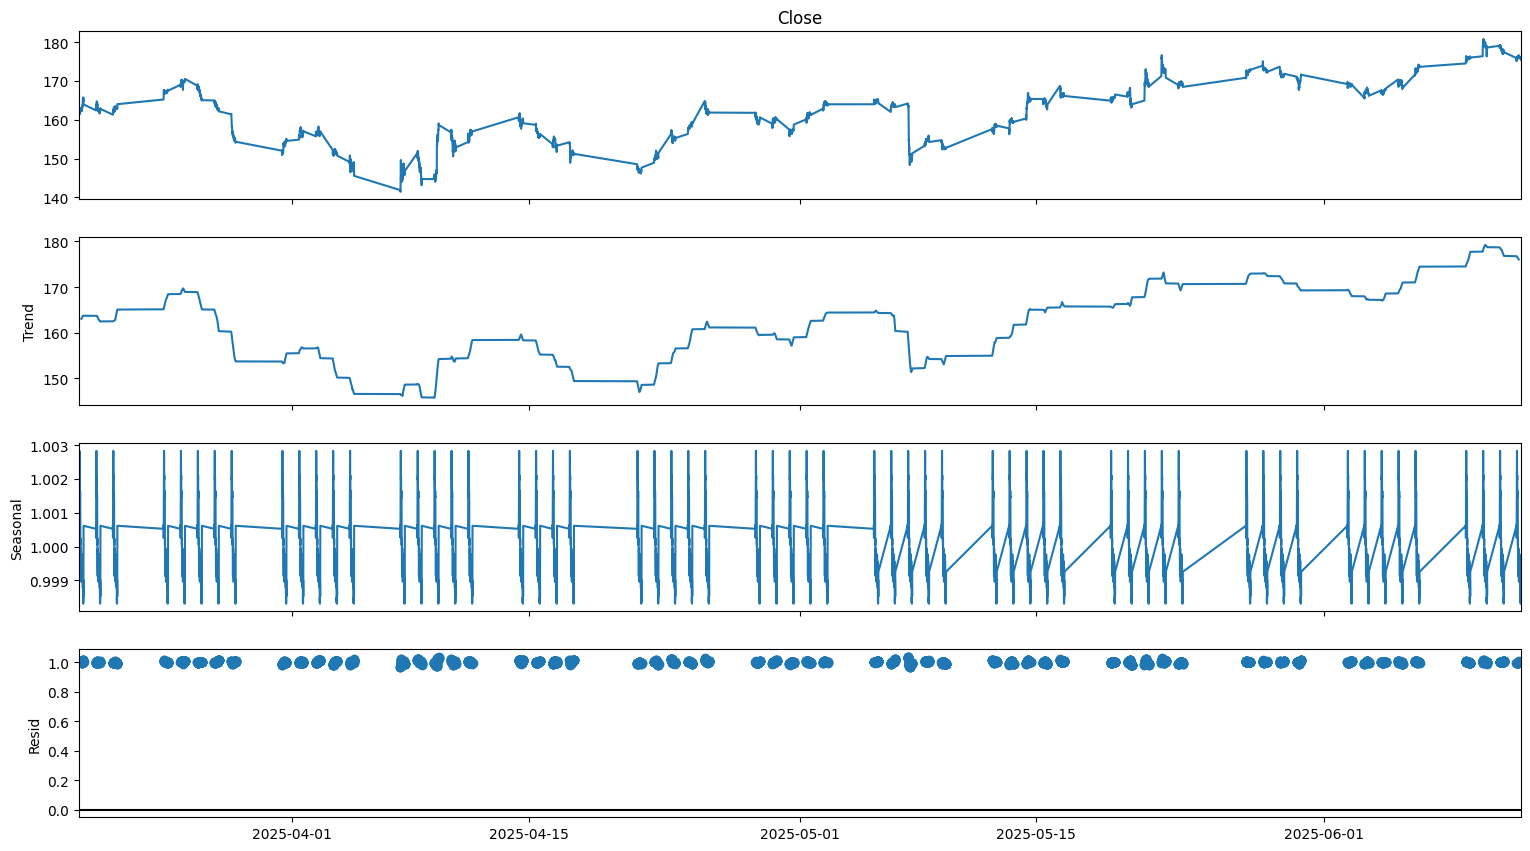

In [429]:
result = seasonal_decompose(msft_df['Close'], model='multiplicative', period = 78)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9);

# Reducing Trend

C:\Users\billy\AppData\Local\Temp\ipykernel_41332\2672323671.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


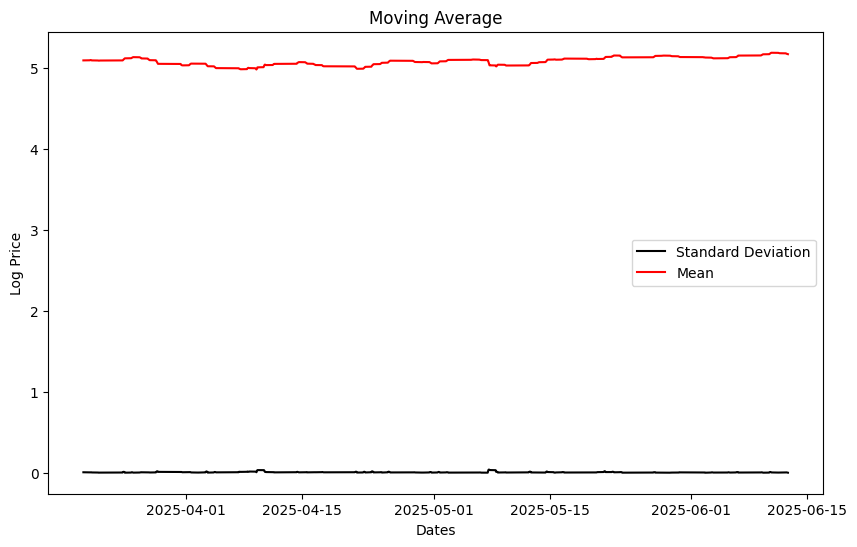

In [430]:
rcParams['figure.figsize'] = 10, 6
msft_log = np.log(msft_df['Close'])
moving_avg = msft_log.rolling(78).mean()
std_dev = msft_log.rolling(78).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.xlabel('Dates')
plt.ylabel('Log Price')
plt.legend()
plt.show()

# Train/Test 

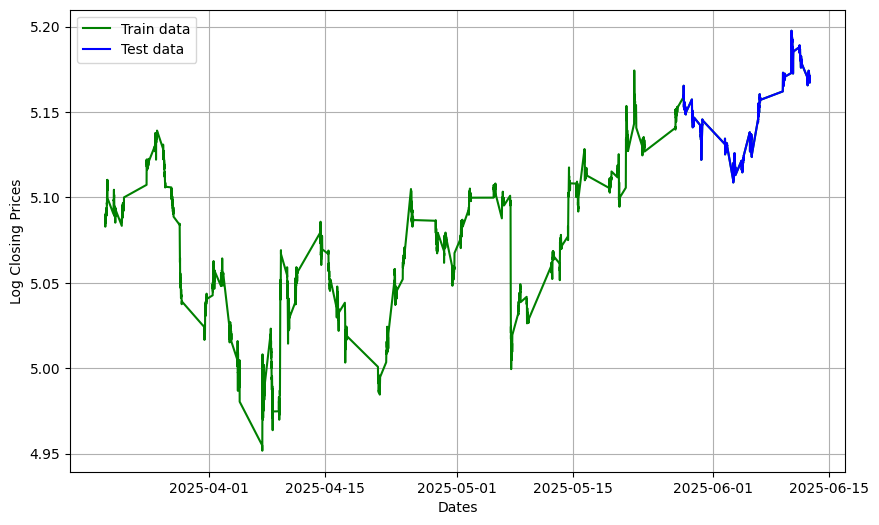

In [431]:
train_size = int(len(msft_df) * 0.8)
train_data, test_data =  msft_log.iloc[:train_size], msft_log.iloc[train_size:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log Closing Prices')
plt.plot(msft_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend();

# HyperParameter Tuning: P, D, Q

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: '

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33058.776, Time=0.26 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33056.866, Time=2.08 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-33056.861, Time=0.62 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33060.634, Time=0.24 sec


c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-33054.775, Time=1.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.402 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3743
Model:               SARIMAX(0, 1, 0)   Log Likelihood               16531.317
Date:                Thu, 12 Jun 2025   AIC                         -33060.634
Time:                        23:18:39   BIC                         -33054.407
Sample:                             0   HQIC                        -33058.419
                               - 3743                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.515e-06    4.5e-08    189.279      0.000    8.43e-0

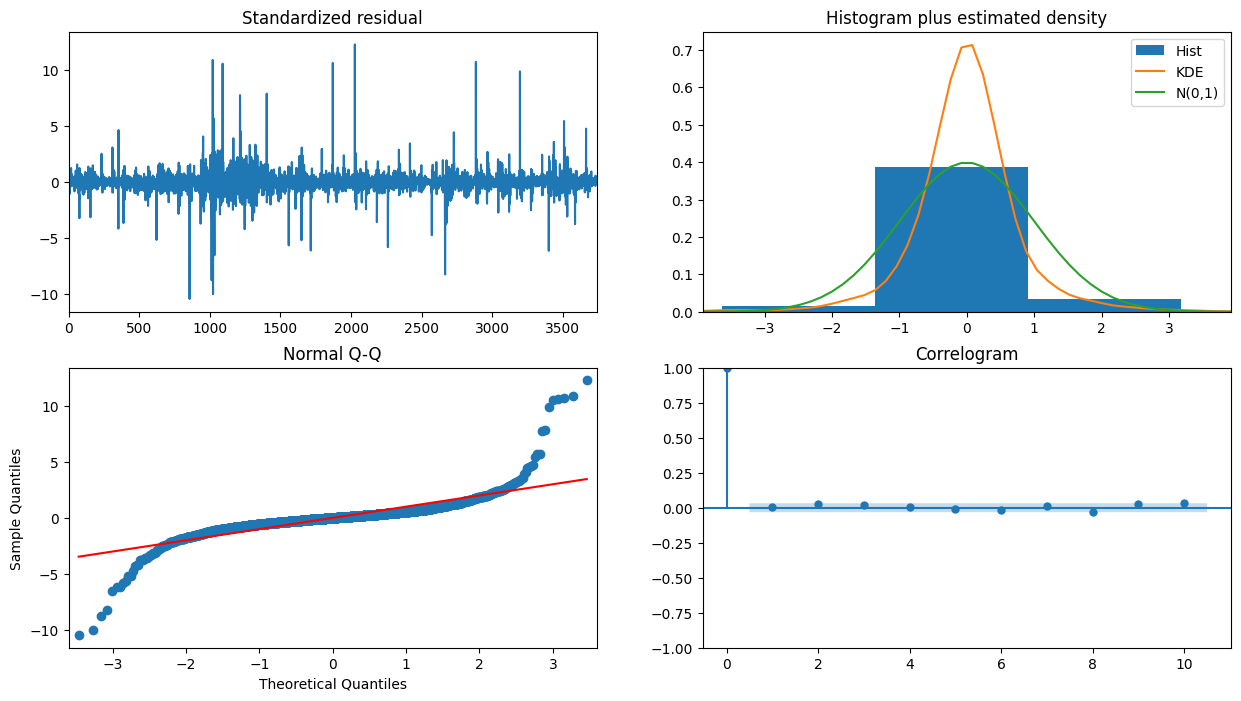

In [432]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# Fit Model with Optimal Parameters

In [433]:
best_p, best_d, bestq = model_autoARIMA.order
arima_fitted = ARIMA(train_data, order=(best_p,best_d,bestq)).fit()
print(arima_fitted.summary())

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3743
Model:                 ARIMA(0, 1, 0)   Log Likelihood               16531.317
Date:                Thu, 12 Jun 2025   AIC                         -33060.634
Time:                        23:18:41   BIC                         -33054.407
Sample:                             0   HQIC                        -33058.419
                               - 3743                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.515e-06    4.5e-08    189.279      0.000    8.43e-06     8.6e-06
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):            205740.08
Prob(Q):                              0.76   Pr

In [434]:
forecast.min()

4.799899710796877

In [435]:
forecast.max()

4.799899710796877

In [436]:
forecast

2012    4.7999
2013    4.7999
2014    4.7999
2015    4.7999
2016    4.7999
         ...  
2510    4.7999
2511    4.7999
2512    4.7999
2513    4.7999
2514    4.7999
Name: predicted_mean, Length: 503, dtype: float64

c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\billy\anaconda3\envs\stock_predictions\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


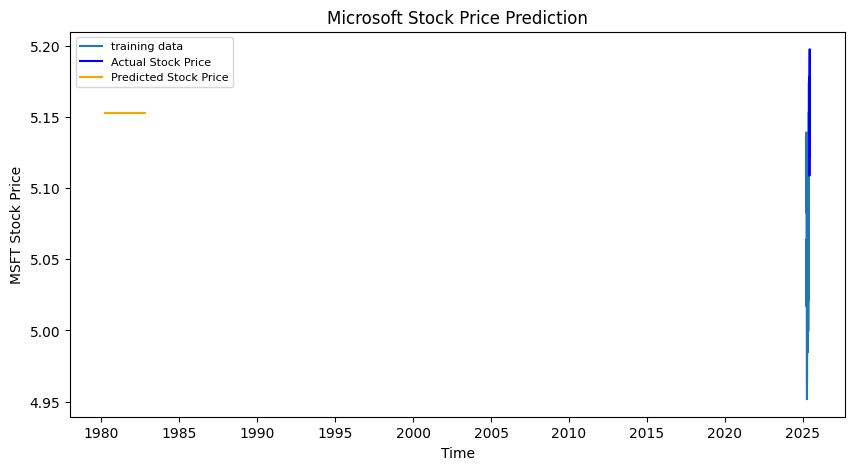

In [437]:
forecast = arima_fitted.forecast(steps=len(test_data))
plt.figure(figsize=(10,5))
plt.plot(train_data.index, train_data,  label='training data')
plt.plot(test_data.index, test_data, color = 'blue', label='Actual Stock Price')
plt.plot(forecast.index, forecast, color = 'orange',label='Predicted Stock Price')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('MSFT Stock Price')
plt.legend(loc='upper left', fontsize=8)
#plt.savefig("3mo.png", dpi=300, bbox_inches="tight")
plt.show()

In [438]:
mean_squared_error(test_data, forecast), mean_absolute_error(test_data, forecast), mean_absolute_percentage_error(test_data, forecast)   

(0.0005315385942139723, 0.019863778866062002, 0.0038574690560609364)

In [439]:
metrics = {
"MSE": mean_squared_error(test_data, forecast), 
"RMSE": np.sqrt(mean_squared_error(test_data, forecast)),
"MAE": mean_absolute_error(test_data, forecast), 
"MAPE": mean_absolute_percentage_error(test_data, forecast)
}
#df_metrics = pd.DataFrame(metrics, index=[0])
#df_metrics.to_csv('3mo_MSFT_metrics.csv', index=False)
